<a href="https://colab.research.google.com/github/mohammedterry/NLP_for_ML/blob/master/Sentence_Embedding_Benchmarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test 1: Synonymous Sentences
* **Aim**: This test will check how good each method is at embedding sentences with the same meaning but phrased differently and using different words.  
* **Expectations**: Regardless of the different words and phrasing used, it is the meaning of the sentence which is being captured by the embedding method (ideally).  Therefore the better method will create similar numerical representations (i.e. sentence vectors) for sentences with similar meanings.  

## Test Data
Lets download a csv file containing some sentences for testing

In [0]:
!wget https://raw.githubusercontent.com/mohammedterry/NLP_for_ML/master/synonymous_sentences.csv

--2019-03-16 09:42:00--  https://raw.githubusercontent.com/mohammedterry/NLP_for_ML/master/synonymous_sentences.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 424 [text/plain]
Saving to: ‘synonymous_sentences.csv’

synonymous_sentence 100%[===================>]     424  --.-KB/s    in 0s      

2019-03-16 09:42:05 (53.5 MB/s) - ‘synonymous_sentences.csv’ saved [424/424]



In [0]:
import pandas as pd
testbench1 = pd.read_csv("synonymous_sentences.csv")
testbench1

,sentence,rephrase1,rephrase2
0,i have a question,i wanted to ask you about something,can i ask you a question
1,can you play any good music,i d like to listen to a nice tune while i wait,play me something pleasant please
2,is it raining today,will it be sunny this afternoon,whats the weather like
3,please remind me about that at 6 O clock,set reminder for 6 pm,can you put that in my calendar for this eveni...


In [0]:
test_sentences = testbench1.values.flatten()
test_sentences

array(['i have a question', 'i wanted to ask you about something',
       'can i ask you a question', 'can you play any good music',
       'i d like to listen to a nice tune while i wait',
       'play me something pleasant please', 'is it raining today',
       'will it be sunny this afternoon', 'whats the weather like',
       'please remind me about that at 6 O clock',
       'set reminder for 6 pm',
       'can you put that in my calendar for this evening around about 6 or so'],
      dtype=object)

In [0]:
rows,cols = testbench1.shape
meanings = [i for i in range(rows) for _ in range(cols)]
meanings

[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]

## Test Method
For each sentence, we find the top two most similar sentences (according to how it has been encoded) using cosine similarity (NB: we could use other measures here).  We limit it to the top 2 because there are usually only 2 ways the sentence is rephrased in the test set (however, feel free to add more). 

**Scoring System:** 
* we give a full point if the top 2 most similar sentences have the same meaning as the target sentence. 
* We award 0.5 points if the top most similar sentence only had the same meaning as the target sentence.  
* 0.25 points are awarded if the second most similar sentence returned happened to have the same meaning as the target sentence but the top most similar did not
* The mean is then computed for the final score (total points / number of questions tested) )

In [0]:
def most_similar(vector, other_vectors, top_n = 3):
  from scipy.spatial.distance import cosine
  scores = [cosine(vector, vec) for vec in other_vectors]
  ranked_candidates_idx = sorted([(score,idx) for idx,score in enumerate(scores)])
  ranked_candidates = [idx for _,idx in ranked_candidates_idx[:top_n]]
  return ranked_candidates

def score(predicted_sentences, expected_sentences):
  points = 0
  for predicted,expected in zip(predicted_sentences, expected_sentences):
    y_hat1,y_hat2 = predicted
    if y_hat1 == expected:
      if y_hat2 == expected:
        points += 1
      else:
        points += .5
    elif y_hat2 == expected:
      points += .25
  return points / len(predicted_sentences)

def test1(svectors, topics, display = False):
  predicted_sentences = [most_similar(svector, svectors) for svector in svectors]
  if display:
    marks = ("❌","✅")
    for sentence,t,ppp in zip(test_sentences,topics,predicted_sentences):
      p1,p2,p3 = ppp
      t1 = topics[p1]
      t2 = topics[p2]
      t3 = topics[p3]
      print(f"\n({t}) {sentence}:\n{marks[t1 == t]}\t({t1}) {test_sentences[p1]}\n{marks[t2 == t]}\t({t2}) {test_sentences[p2]}\n{marks[t3 == t]}\t({t3}) {test_sentences[p3]}")
  predicted_topics = [(topics[p2],topics[p3]) for _,p2,p3 in predicted_sentences]
  return score(predicted_topics, topics)

## Visualising the Results
We need a way to compare the encoded sentence vectors in a human-interpretable way
* Therefore, we can visualise each sentence's vector as a position on a graph
* However, sentence vectors typically have hundreds of dimensions (100-300 values in their vector), whereas we only need 3 values to plot them on a graph (x,y,z).  So which 3 values should we use? To solve this problem, we can perform Principal Component Analysis PCA to essentially reduce the vector dimensions down from 300 to 3. 
* Sentences with the same meaning are coloured identically to make them more easily identifiable when plotted  
* If the sentence embedding method is good, we would expect to see sentences of the same meaning (same colour) having a very similar vector representation (similar position on the graph)

In [0]:
%matplotlib inline

def plot_sentences(sentences, svectors, colours):
  from sklearn.decomposition import PCA
  pca = PCA(n_components=3)
  principalComponents = pca.fit_transform(svectors)
  
  import pandas as pd
  dataframe = pd.DataFrame(data = principalComponents, columns = ['x', 'y','z'])

  import seaborn as sns
  sns.set_style("whitegrid")
  dataframe['colour'] = pd.Series([sns.color_palette()[i] for i in colours])
  
  import matplotlib.pyplot as plt, mpl_toolkits.mplot3d
  fig = plt.figure()
  graph = fig.gca(projection='3d')
  [graph.text(x, z, y, s, 'x', color = c) for x, y, z, s, c in zip(dataframe['x'], dataframe['y'], dataframe['z'], sentences, dataframe['colour'])]
  graph.set_xlim(min(dataframe['x']), max(dataframe['x']))
  graph.set_ylim(min(dataframe['z']), max(dataframe['z']))
  graph.set_zlim(min(dataframe['y']), max(dataframe['y']))
  plt.show()
  
  graph2=sns.regplot(data=dataframe, x="x", y="y", fit_reg=False, marker="+")
  [graph2.text(x, y, s,color=c) for x,y,s,c in zip(dataframe['x'],dataframe['y'],sentences,dataframe["colour"])]

## Results

In [0]:
results = {"method":[],"test1":[]}

### Bag of Words
We begin with one of the simplest methods to convert sentences into vectors.  We create a vector the size of the vocabulary we are working with, then we assign a word to each position in that vector.  To encode a sentence, we assign a 1 to the relevant positions  in the sentence's vector for each word in the sentence.  All other positions are set to 0.
![alt text](http://www.illuminationworksllc.com/wp-content/uploads/2017/01/bag_diagram.png)

**Pros & Cons:**
* (pro) Super Simple
* (con) Vector size depends on the size of the vocabulary (this can be large)
* (con) This method also assumes words are unrelated which is not true (e.g. "is" and "are" would be given different positions in the vector and share no relation).  
* (con) Word order is also lost using this method

In [0]:
def bow_vector(sentences, bag_of_words):
  vec_len = len(bag_of_words)
  idxs = [[bag_of_words.index(word) for word in sentence.lower().split()] for sentence in sentences]
  return [[1 if i in idx else 0 for i in range(vec_len)] for idx in idxs]

In [0]:
vocab = list({word for sentence in test_sentences for word in sentence.lower().split()})
bow_vectors = bow_vector(test_sentences, vocab)

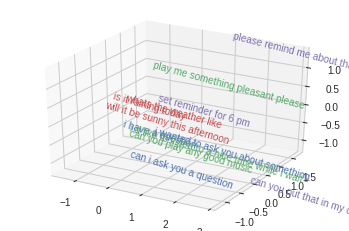

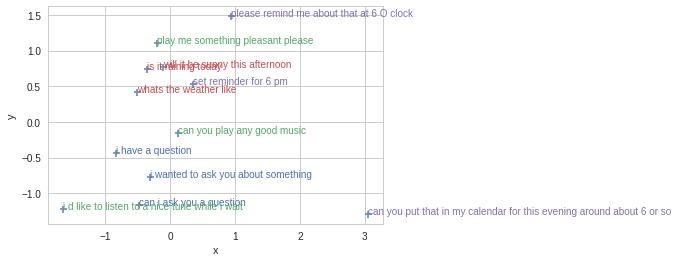

In [0]:
plot_sentences(test_sentences, bow_vectors, meanings)

In [0]:
results["method"].append("Bag of Words")
results["test1"].append(test1(bow_vectors, meanings, display=True))


(0) i have a question:
✅	(0) i have a question
✅	(0) can i ask you a question
❌	(1) i d like to listen to a nice tune while i wait

(0) i wanted to ask you about something:
✅	(0) i wanted to ask you about something
✅	(0) can i ask you a question
❌	(1) i d like to listen to a nice tune while i wait

(0) can i ask you a question:
✅	(0) can i ask you a question
✅	(0) i have a question
✅	(0) i wanted to ask you about something

(1) can you play any good music:
✅	(1) can you play any good music
❌	(0) can i ask you a question
❌	(3) can you put that in my calendar for this evening around about 6 or so

(1) i d like to listen to a nice tune while i wait:
✅	(1) i d like to listen to a nice tune while i wait
❌	(0) i have a question
❌	(0) can i ask you a question

(1) play me something pleasant please:
✅	(1) play me something pleasant please
❌	(3) please remind me about that at 6 O clock
✅	(1) can you play any good music

(2) is it raining today:
✅	(2) is it raining today
✅	(2) will it be sunny 

## Spacy
This is actually a library which includes word vectors. It also combines the word vectors for us into a single sentence vector.
![alt text](https://d33wubrfki0l68.cloudfront.net/d98f48d0e9cef445c040d5b1cf56ab0185347821/07d63/blog/img/spacy-pipelines.jpg)
**Pros & Cons**
* (Pro) Simple to use

In [0]:
import spacy
!python3 -m spacy download en_core_web_lg
sp = spacy.load('en_core_web_lg') 

In [0]:
spacy_vectors = [sp(sentence).vector for sentence in test_sentences]

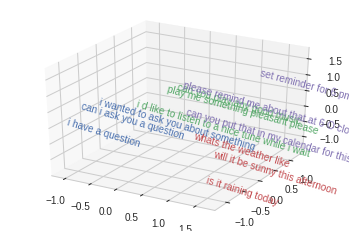

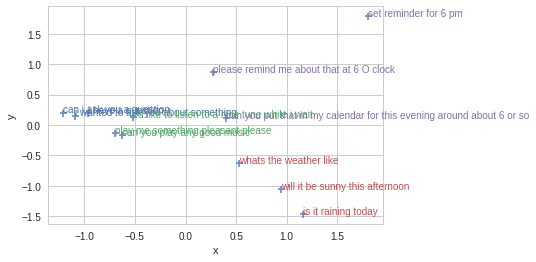

In [0]:
plot_sentences(test_sentences, spacy_vectors, meanings)

In [0]:
results["method"].append("Spacy")
results["test1"].append(test1(spacy_vectors, meanings, display=True))


(0) i have a question:
✅	(0) i have a question
✅	(0) can i ask you a question
✅	(0) i wanted to ask you about something

(0) i wanted to ask you about something:
✅	(0) i wanted to ask you about something
✅	(0) can i ask you a question
❌	(1) i d like to listen to a nice tune while i wait

(0) can i ask you a question:
✅	(0) can i ask you a question
✅	(0) i wanted to ask you about something
✅	(0) i have a question

(1) can you play any good music:
✅	(1) can you play any good music
✅	(1) play me something pleasant please
❌	(3) can you put that in my calendar for this evening around about 6 or so

(1) i d like to listen to a nice tune while i wait:
✅	(1) i d like to listen to a nice tune while i wait
❌	(0) i wanted to ask you about something
❌	(0) can i ask you a question

(1) play me something pleasant please:
✅	(1) play me something pleasant please
❌	(0) i wanted to ask you about something
✅	(1) can you play any good music

(2) is it raining today:
✅	(2) is it raining today
✅	(2) will i

## Char2Vec
Similar to word2vec but for characters.  Instead of building a sentence vector from words, it builds it from the individual letters (and their sequential order).

**Pros & Cons**
* (pro) Since it builds the representation from the characters rather than words, it is more robust to spelling mistakes
* (pro) Generates different embeddings depending on the order of letters
* (cons) It may represent sentences with very different sequences of letters as different, even though the sentences meanings may be similar. 

In [22]:
!pip3 install chars2vec
import chars2vec
c2v_model = chars2vec.load_model('eng_150')

In [0]:
c2v_vectors = c2v_model.vectorize_words(test_sentences)

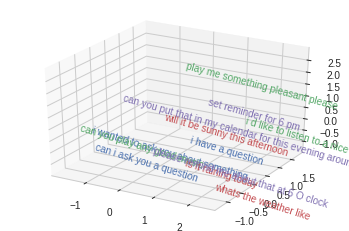

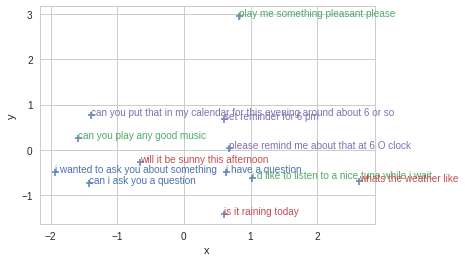

In [0]:
plot_sentences(test_sentences, c2v_vectors, meanings)

In [0]:
results["method"].append("Char2Vec")
results["test1"].append(test1(c2v_vectors, meanings, display=True))


(0) i have a question:
✅	(0) i have a question
❌	(2) will it be sunny this afternoon
❌	(1) i d like to listen to a nice tune while i wait

(0) i wanted to ask you about something:
✅	(0) i wanted to ask you about something
✅	(0) can i ask you a question
❌	(3) can you put that in my calendar for this evening around about 6 or so

(0) can i ask you a question:
✅	(0) can i ask you a question
✅	(0) i wanted to ask you about something
❌	(1) can you play any good music

(1) can you play any good music:
✅	(1) can you play any good music
❌	(0) can i ask you a question
❌	(0) i wanted to ask you about something

(1) i d like to listen to a nice tune while i wait:
✅	(1) i d like to listen to a nice tune while i wait
❌	(3) set reminder for 6 pm
❌	(0) i have a question

(1) play me something pleasant please:
✅	(1) play me something pleasant please
❌	(3) set reminder for 6 pm
❌	(3) can you put that in my calendar for this evening around about 6 or so

(2) is it raining today:
✅	(2) is it raining tod

## Doc2Vec
The Doc2Vec method is similar to the popular Word2Vec method (which uses the surrounding words that often appear alongside a word to incorporate local context into each word's vector representation)
![alt text](https://cdn-images-1.medium.com/max/1600/0*3mnpv-5OwXzjQBNI.gif)
Unlike Word2Vec however, Doc2vec also encorporates globally contextualised information into each word's vector by noting which document the word appeared in too 
![alt text](https://www.groundai.com/media/arxiv_projects/14871/lda2vec_network_publish.png.344x181_q75_crop.png)

In [0]:
#!wget -v -O enwiki_dbow.tgz -L https://ibm.ent.box.com/s/3f160t4xpuya9an935k84ig465gvymm2
#!tar -xvzf enwiki_dbow.tgz

from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!mkdir doc2vec
!cp -r gdrive/My\ Drive/Codes_Projects/publishing/xploro2.0_NLU/sentence_vectors/d2v_enwiki/* doc2vec/

In [25]:
import gensim
model_path = "doc2vec/doc2vec.bin"
d2v_model = gensim.models.doc2vec.Doc2Vec.load(model_path)

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [0]:
d2v_vectors = [d2v_model.infer_vector(sentence.lower().split(), alpha=.01, steps=1000) for sentence in test_sentences]

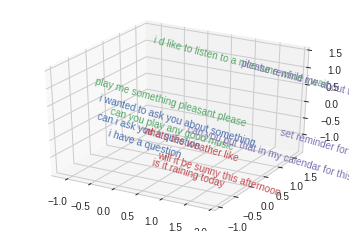

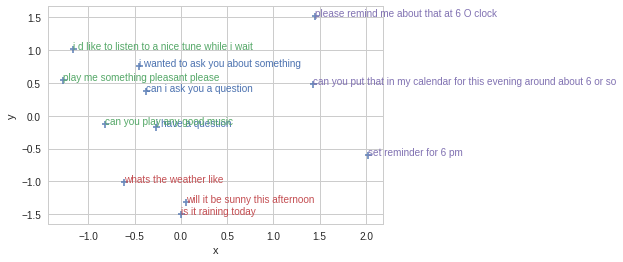

In [0]:
plot_sentences(test_sentences, d2v_vectors, meanings)

In [0]:
results["method"].append("Doc2Vec")
results["test1"].append(test1(d2v_vectors, meanings, display=True))


(0) i have a question:
✅	(0) i have a question
✅	(0) can i ask you a question
✅	(0) i wanted to ask you about something

(0) i wanted to ask you about something:
✅	(0) i wanted to ask you about something
✅	(0) can i ask you a question
✅	(0) i have a question

(0) can i ask you a question:
✅	(0) can i ask you a question
✅	(0) i have a question
✅	(0) i wanted to ask you about something

(1) can you play any good music:
✅	(1) can you play any good music
✅	(1) play me something pleasant please
❌	(0) can i ask you a question

(1) i d like to listen to a nice tune while i wait:
✅	(1) i d like to listen to a nice tune while i wait
✅	(1) can you play any good music
❌	(0) i wanted to ask you about something

(1) play me something pleasant please:
✅	(1) play me something pleasant please
✅	(1) can you play any good music
❌	(0) i wanted to ask you about something

(2) is it raining today:
✅	(2) is it raining today
✅	(2) will it be sunny this afternoon
✅	(2) whats the weather like

(2) will it be 

## BERT
BERT is a fine-tuned language model which has naturally learnt to capture the semantics of words and sentences.  The hidden layer of the final step can be taken as the semantic representation of the sentence. 

tokens = ["[CLS]"] + tokens_a + ["[SEP]"]

(Note: the final step actually corresponds to the vector for the first token -  [CLS])

![alt text](https://www.depends-on-the-definition.com/wp-content/uploads/2018/12/bert-input-output-945x362.png)

**Pros & Cons**
* (Pro) preserves word order
* (Con) the sentence vectors are sometimes unpredictable, especially for longer sentences

In [26]:
!pip3 install pytorch_pretrained_bert

from pytorch_pretrained_bert import BertTokenizer
tokeniser = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case = True)

from pytorch_pretrained_bert import BertModel
bert = BertModel.from_pretrained('bert-large-uncased')

import torch
def sentence_bert(sentence):
  tokenised_sentence = ["[CLS]"] + tokeniser.tokenize(sentence) +  ["[SEP]"]
  tokens_tensor = torch.tensor([tokeniser.convert_tokens_to_ids(tokenised_sentence)])
  segments_tensor = torch.tensor([[0 for _ in range(len(tokenised_sentence))]])
  encoded_layers, _ = bert(tokens_tensor, segments_tensor)
  sent_vector = encoded_layers[0][-1][0]
  return sent_vector.detach().numpy()

    100% |████████████████████████████████| 122kB 3.7MB/s 
Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


100%|██████████| 1248501532/1248501532 [00:22<00:00, 55329600.63B/s]


In [0]:
bert_vectors = [sentence_bert(sentence) for sentence in test_sentences]

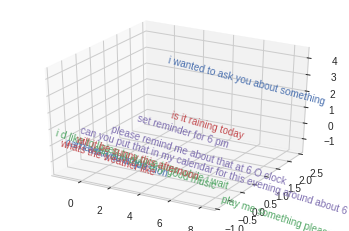

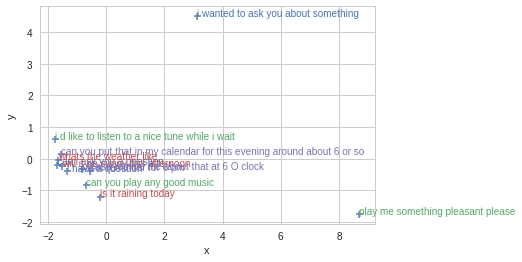

In [0]:
plot_sentences(test_sentences, bert_vectors, meanings)

In [0]:
results["method"].append("BERT")
results["test1"].append(test1(bert_vectors, meanings, display=True))


(0) i have a question:
✅	(0) i have a question
✅	(0) can i ask you a question
❌	(2) whats the weather like

(0) i wanted to ask you about something:
✅	(0) i wanted to ask you about something
❌	(3) please remind me about that at 6 O clock
❌	(1) i d like to listen to a nice tune while i wait

(0) can i ask you a question:
✅	(0) can i ask you a question
✅	(0) i have a question
❌	(2) will it be sunny this afternoon

(1) can you play any good music:
✅	(1) can you play any good music
❌	(0) can i ask you a question
❌	(2) will it be sunny this afternoon

(1) i d like to listen to a nice tune while i wait:
✅	(1) i d like to listen to a nice tune while i wait
❌	(2) whats the weather like
❌	(3) can you put that in my calendar for this evening around about 6 or so

(1) play me something pleasant please:
✅	(1) play me something pleasant please
❌	(0) i wanted to ask you about something
❌	(2) is it raining today

(2) is it raining today:
✅	(2) is it raining today
❌	(3) please remind me about that at

## Universal Encoder
This is an end-to-end model trained to generate single, fixed-length sentence vectors for any sentence it is given (regardless of how many words it has)
![alt text](http://nlp.town/assets/img/blog/sensim.png)

In [27]:
import tensorflow as tf
import tensorflow_hub as hub

tf.logging.set_verbosity(tf.logging.ERROR)

module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(module_url)

def universal_sentence(sentences):
  with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    vectors = session.run(embed(sentences))
    return vectors

W0316 22:29:13.437903 140167606228864 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [0]:
uni_vectors = universal_sentence(test_sentences)

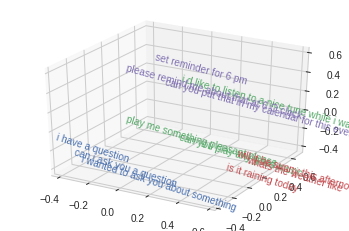

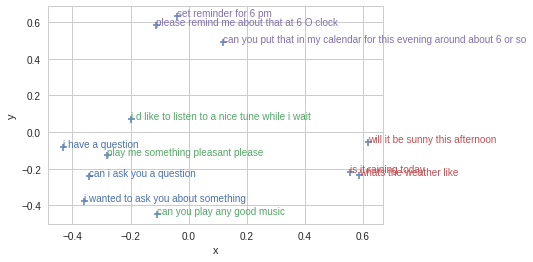

In [0]:
plot_sentences(test_sentences, uni_vectors, meanings)

In [0]:
results["method"].append("Universal Encoder")
results["test1"].append(test1(uni_vectors, meanings, display=True))


(0) i have a question:
✅	(0) i have a question
✅	(0) can i ask you a question
✅	(0) i wanted to ask you about something

(0) i wanted to ask you about something:
✅	(0) i wanted to ask you about something
✅	(0) can i ask you a question
✅	(0) i have a question

(0) can i ask you a question:
✅	(0) can i ask you a question
✅	(0) i wanted to ask you about something
✅	(0) i have a question

(1) can you play any good music:
✅	(1) can you play any good music
✅	(1) play me something pleasant please
✅	(1) i d like to listen to a nice tune while i wait

(1) i d like to listen to a nice tune while i wait:
✅	(1) i d like to listen to a nice tune while i wait
✅	(1) can you play any good music
❌	(3) set reminder for 6 pm

(1) play me something pleasant please:
✅	(1) play me something pleasant please
❌	(0) can i ask you a question
✅	(1) can you play any good music

(2) is it raining today:
✅	(2) is it raining today
✅	(2) will it be sunny this afternoon
✅	(2) whats the weather like

(2) will it be sun

## Stacked Embeddings
Here we concatenate the sentence vectors produced by various methods into one long sentence vector to combine their various strengths (and weaknesses)

In [0]:
import numpy as np

stacked_vectors = [np.concatenate(stack) for stack in zip(bow_vectors, d2v_vectors, spacy_vectors, c2v_vectors, bert_vectors, uni_vectors)]

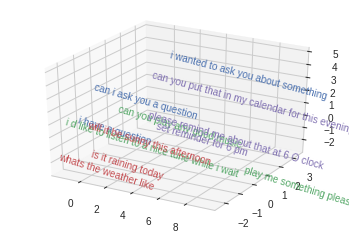

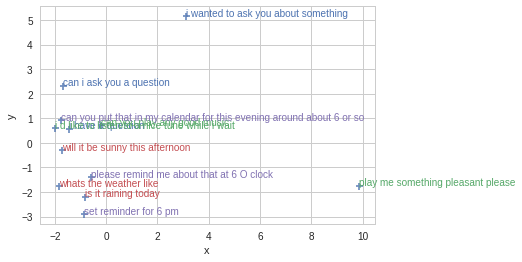

In [0]:
plot_sentences(test_sentences, stacked_vectors, meanings)

In [0]:
results["method"].append("Stacked")
results["test1"].append(test1(stacked_vectors, meanings, display=True))


(0) i have a question:
✅	(0) i have a question
✅	(0) can i ask you a question
❌	(2) will it be sunny this afternoon

(0) i wanted to ask you about something:
✅	(0) i wanted to ask you about something
✅	(0) can i ask you a question
✅	(0) i have a question

(0) can i ask you a question:
✅	(0) can i ask you a question
✅	(0) i have a question
❌	(1) can you play any good music

(1) can you play any good music:
✅	(1) can you play any good music
❌	(0) can i ask you a question
❌	(0) i have a question

(1) i d like to listen to a nice tune while i wait:
✅	(1) i d like to listen to a nice tune while i wait
❌	(0) i have a question
❌	(0) can i ask you a question

(1) play me something pleasant please:
✅	(1) play me something pleasant please
❌	(0) i wanted to ask you about something
✅	(1) can you play any good music

(2) is it raining today:
✅	(2) is it raining today
✅	(2) will it be sunny this afternoon
❌	(0) i have a question

(2) will it be sunny this afternoon:
✅	(2) will it be sunny this afte

## Word Mover Distance (WMD)
This method avoids creating a single vector for a sentence.  Instead it represents sentences as multiple word vectors.  Usually we need to represent each sentence as a single vector of the same size so that they can be compared with one another mathematically, however, this method gets around this limitation using a technique that compares the individual word vectors to the closest word vectors in the other sentences.


![alt text](https://raw.github.com/RaRe-Technologies/movie-plots-by-genre/master/ipynb_with_output/images/wmd_gelato.png)

**Pros & Cons**
* (Pro) It is light-weight since no pre-trained algorithms are required 
* (Pro) Word vectors are required (we load Word2Vec embeddings for this test, however, custom word vectors can be used instead)
* (Pro)  Sentences of differing lengths can be represented and compared without a problem
* (Con) The sentence's Word Order is not preserved

In [50]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
from gensim.models import KeyedVectors
w2v = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

--2019-03-16 22:36:42--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.164.85
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.164.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  76.5MB/s    in 19s     

2019-03-16 22:37:01 (81.9 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
def most_similar_wmd(sentence, other_sentences, top_n = 3):
  scores = [w2v.wmdistance(sentence.lower().split(), other_sentence.lower().split()) for other_sentence in other_sentences]
  ranked_candidates_idx = sorted([(score,idx) for idx,score in enumerate(scores)])
  ranked_candidates = [idx for _,idx in ranked_candidates_idx[:top_n]]
  return ranked_candidates

def test1_wmd(sentences, topics, display = False):
  predicted_sentences = [most_similar_wmd(sentence, sentences) for sentence in sentences]
  if display:
    marks = ("❌","✅")
    for sentence,t,ppp in zip(sentences,topics,predicted_sentences):
      p1,p2,p3 = ppp
      t1 = topics[p1]
      t2 = topics[p2]
      t3 = topics[p3]      
      print(f"\n({t}) {sentence}:\n{marks[t1 == t]}\t({t1}) {test_sentences[p1]}\n{marks[t2 == t]}\t({t2}) {test_sentences[p2]}\n{marks[t3 == t]}\t({t3}) {test_sentences[p3]}")
  predicted_topics = [(topics[p2],topics[p3]) for _,p2,p3 in predicted_sentences]
  return score(predicted_topics, topics)

In [0]:
results["method"].append("Word Mover Distances")
results["test1"].append(test1_wmd(test_sentences, meanings, display=True))


(0) i have a question:
✅	(0) i have a question
✅	(0) can i ask you a question
✅	(0) i wanted to ask you about something

(0) i wanted to ask you about something:
✅	(0) i wanted to ask you about something
✅	(0) can i ask you a question
✅	(0) i have a question

(0) can i ask you a question:
✅	(0) can i ask you a question
✅	(0) i wanted to ask you about something
✅	(0) i have a question

(1) can you play any good music:
✅	(1) can you play any good music
❌	(0) can i ask you a question
❌	(3) can you put that in my calendar for this evening around about 6 or so

(1) i d like to listen to a nice tune while i wait:
✅	(1) i d like to listen to a nice tune while i wait
❌	(0) i wanted to ask you about something
❌	(0) i have a question

(1) play me something pleasant please:
✅	(1) play me something pleasant please
✅	(1) can you play any good music
❌	(3) please remind me about that at 6 O clock

(2) is it raining today:
✅	(2) is it raining today
✅	(2) will it be sunny this afternoon
❌	(3) can you 

## Pooled Word Vectors 
The idea with this method is to encode each word in the sentence into a word vector.  Then each word vector is combined together to form a single sentence, fixed-size sentence vector.  

Pooling methods to combine word vectors together include: 

* Max/Min Pooling (we shall not explore these)
* Sum Pooling (simply adding all the vectors together)
* Mean Pooling  (averaging all the vectors together)
* Tf-Idf Weighted Mean Pooling (averaging all the vectors together but weighted according to how important the word is - importance is determined using Tf-Idf)
* RNN Pooling (combining all the word vectors together using a Recurrent Neural Network/RNN)
* CNN Pooling (combing all the word vectors together using a Convolutional Neural Network)

# Test1 Results

In [0]:
import pandas as pd
pd.DataFrame(results)

,method,test1
0,Bag of Words,0.458333
1,Spacy,0.479167
2,Char2Vec,0.104167
3,Doc2Vec,0.625000
4,BERT,0.208333
5,Universal Encoder,0.895833
6,Stacked,0.354167
7,Word Mover Distances,0.562500


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


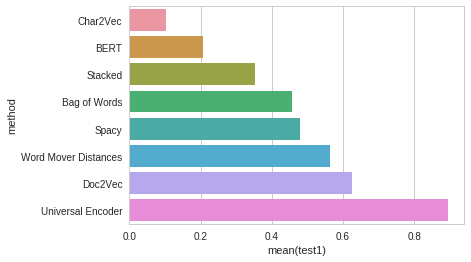

In [0]:
results_df = pd.DataFrame(results).sort_values(['test1']).reset_index(drop=True)
sns.barplot(x="test1", y="method", data=results_df)

# Test 2: Domain-Specific
Same test as above but this time with some domain-specific sentences

## Test Data

In [32]:
!wget https://raw.githubusercontent.com/mohammedterry/NLP_for_ML/master/synonymous_medical_sentences.csv

--2019-03-16 22:30:23--  https://raw.githubusercontent.com/mohammedterry/NLP_for_ML/master/synonymous_medical_sentences.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1896 (1.9K) [text/plain]
Saving to: ‘synonymous_medical_sentences.csv’

synonymous_medical_ 100%[===================>]   1.85K  --.-KB/s    in 0s      

2019-03-16 22:30:24 (263 MB/s) - ‘synonymous_medical_sentences.csv’ saved [1896/1896]



In [33]:
import pandas as pd
testbench2 = pd.read_csv("synonymous_medical_sentences.csv")
testbench2

,sentence,variant1,variant2,variant3,variant4
0,How is brain cancer diagnosed ?,How do they know I've got brain cancer ?,How can they tell I've got brain cancer ?,How will they tell if I have brain cancer,How will I find out if I have brain cancer ?
1,Does bone marrow cancer hurt ?,Will bone marrow cancer hurt ?,Will bone marrow cancer be painful ?,How much will bone marrow cancer hurt ?,Is bone marrow cancer going to hurt ?
2,What does paediatric mean ?,What's paediactric ?,I don't know what paediactric means,Do you know what paediatric means ?,paediatric ?
3,Does the sun cause cancer?,Do you get cancer from the sun,have I got cancer from the sun,how do you get cancer from the sun,Can the sun cause cancer ?
4,Why doesn't the doctor do my blood test ?,does a doctor do blood tests ?,why doesn't a doctor do blood tests,Why does the nurse do my blood test and not a ...,Does a doctor do my blood test ?
5,Can my hickman line get wet ?,does it matter if my hickman line gets wet,I got my hickman line wet,what should I do if I get my hickman line wet,what if I get water on my hickman line
6,What will a CT scan feel like ?,What does a CT scan feel like ?,Will the CT scan feel funny ?,What will it feel like in the CT scanner ?,does a CT scan hurt ?
7,What am I having treatment for ?,why do I need treatment,What's treatment for ?,what am i getting treated for,why do i need this treatment
8,Can I pray in hospital ?,Is there somewhere to pray in hospital ?,Is there a prayer room in hospital,where can I pray,Am I allowed to pray in hospital ?
9,How do I call a nurse over ?,how do I ask for a nurse ?,How do I get a nurse to come ?,What do I do to get a nurse ?,Can I call a nurse somehow ?


In [0]:
test_sentences2 = testbench2.values.flatten()
rows,cols = testbench2.shape
meanings2 = [i for i in range(rows) for _ in range(cols)]

In [0]:
def test2(svectors, topics, display = False):
  predicted_sentences = [most_similar(svector, svectors, top_n = 5) for svector in svectors]
  if display:
    marks = ("❌","✅")
    for sentence,t,ppp in zip(test_sentences2,topics,predicted_sentences):
      p1,p2,p3,p4,p5 = ppp
      t1 = topics[p1]
      t2 = topics[p2]
      t3 = topics[p3]
      t4 = topics[p4]
      t5 = topics[p5]
      print(f"\n({t}) {sentence}:\n{marks[t1 == t]}\t({t1}) {test_sentences2[p1]}\n{marks[t2 == t]}\t({t2}) {test_sentences2[p2]}\n{marks[t3 == t]}\t({t3}) {test_sentences2[p3]}\n{marks[t4 == t]}\t({t4}) {test_sentences2[p4]}\n{marks[t5 == t]}\t({t5}) {test_sentences2[p5]}")
  predicted_topics = [(topics[p2],topics[p3]) for _,p2,p3,_,_ in predicted_sentences]
  return score(predicted_topics, topics)

In [0]:
results["test2"] = []

### Method: BOWs

In [35]:
vocab = list({word for sentence in test_sentences2 for word in sentence.lower().split()})
bow_vectors2 = bow_vector(test_sentences2, vocab)
results["test2"].append(test2(bow_vectors2, meanings2, display = True))


(0) How is brain cancer diagnosed ?:
✅	(0) How is brain cancer diagnosed ?
✅	(0) How do they know I've got brain cancer ?
✅	(0) How can they tell I've got brain cancer ?
✅	(0) How will I find out if I have brain cancer ?
❌	(1) How much will bone marrow cancer hurt ?

(0) How do they know I've got brain cancer ?:
✅	(0) How do they know I've got brain cancer ?
✅	(0) How can they tell I've got brain cancer ?
✅	(0) How is brain cancer diagnosed ?
✅	(0) How will they tell if I have brain cancer
✅	(0) How will I find out if I have brain cancer ?

(0) How can they tell I've got brain cancer ?:
✅	(0) How can they tell I've got brain cancer ?
✅	(0) How do they know I've got brain cancer ?
✅	(0) How will they tell if I have brain cancer
✅	(0) How is brain cancer diagnosed ?
✅	(0) How will I find out if I have brain cancer ?

(0) How will they tell if I have brain cancer:
✅	(0) How will they tell if I have brain cancer
✅	(0) How will I find out if I have brain cancer ?
✅	(0) How can they tell I'

0.9136363636363637

### Method: Spacy

In [0]:
spacy_vectors2 = [sp(sentence).vector for sentence in test_sentences2]
results["test2"].append(test2(spacy_vectors2, meanings2, display = True))


(0) How is brain cancer diagnosed ?:
✅	(0) How is brain cancer diagnosed ?
❌	(1) Is bone marrow cancer going to hurt ?
❌	(1) How much will bone marrow cancer hurt ?
✅	(0) How can they tell I've got brain cancer ?
✅	(0) How will they tell if I have brain cancer

(0) How do they know I've got brain cancer ?:
✅	(0) How do they know I've got brain cancer ?
✅	(0) How can they tell I've got brain cancer ?
✅	(0) How will I find out if I have brain cancer ?
✅	(0) How will they tell if I have brain cancer
❌	(2) I don't know what paediactric means

(0) How can they tell I've got brain cancer ?:
✅	(0) How can they tell I've got brain cancer ?
✅	(0) How do they know I've got brain cancer ?
✅	(0) How will I find out if I have brain cancer ?
✅	(0) How will they tell if I have brain cancer
❌	(9) How do I get a nurse to come ?

(0) How will they tell if I have brain cancer:
✅	(0) How will they tell if I have brain cancer
✅	(0) How will I find out if I have brain cancer ?
✅	(0) How can they tell I've 

### Method: Char2Vec

In [0]:
c2v_vectors2 = c2v_model.vectorize_words(test_sentences2)
results["test2"].append(test2(c2v_vectors2, meanings2, display = True))


(0) How is brain cancer diagnosed ?:
✅	(0) How is brain cancer diagnosed ?
❌	(1) Will bone marrow cancer hurt ?
❌	(3) have I got cancer from the sun
❌	(1) Does bone marrow cancer hurt ?
❌	(3) Does the sun cause cancer?

(0) How do they know I've got brain cancer ?:
✅	(0) How do they know I've got brain cancer ?
❌	(9) how do I ask for a nurse ?
❌	(3) Does the sun cause cancer?
❌	(6) does a CT scan hurt ?
❌	(1) Does bone marrow cancer hurt ?

(0) How can they tell I've got brain cancer ?:
✅	(0) How can they tell I've got brain cancer ?
❌	(1) How much will bone marrow cancer hurt ?
✅	(0) How will I find out if I have brain cancer ?
❌	(3) Can the sun cause cancer ?
❌	(10) In an operation will I be asleep ?

(0) How will they tell if I have brain cancer:
✅	(0) How will they tell if I have brain cancer
❌	(6) What will it feel like in the CT scanner ?
✅	(0) How will I find out if I have brain cancer ?
❌	(5) I got my hickman line wet
❌	(3) Does the sun cause cancer?

(0) How will I find out i

### Method: Doc2Vec

In [0]:
d2v_vectors2 = [d2v_model.infer_vector(sentence.lower().split(), alpha=.01, steps=1000) for sentence in test_sentences2]
results["test2"].append(test2(d2v_vectors2, meanings2, display = True))


(0) How is brain cancer diagnosed ?:
✅	(0) How is brain cancer diagnosed ?
✅	(0) How do they know I've got brain cancer ?
✅	(0) How can they tell I've got brain cancer ?
✅	(0) How will they tell if I have brain cancer
✅	(0) How will I find out if I have brain cancer ?

(0) How do they know I've got brain cancer ?:
✅	(0) How do they know I've got brain cancer ?
✅	(0) How can they tell I've got brain cancer ?
✅	(0) How is brain cancer diagnosed ?
✅	(0) How will they tell if I have brain cancer
✅	(0) How will I find out if I have brain cancer ?

(0) How can they tell I've got brain cancer ?:
✅	(0) How can they tell I've got brain cancer ?
✅	(0) How do they know I've got brain cancer ?
✅	(0) How will they tell if I have brain cancer
✅	(0) How is brain cancer diagnosed ?
✅	(0) How will I find out if I have brain cancer ?

(0) How will they tell if I have brain cancer:
✅	(0) How will they tell if I have brain cancer
✅	(0) How will I find out if I have brain cancer ?
✅	(0) How can they tell 

### Method: BERT

In [0]:
bert_vectors2 = [sentence_bert(sentence) for sentence in test_sentences2]
results["test2"].append(test2(bert_vectors2, meanings2, display = True))


(0) How is brain cancer diagnosed ?:
✅	(0) How is brain cancer diagnosed ?
❌	(1) Is bone marrow cancer going to hurt ?
❌	(10) Will I sleep all through my operation ?
✅	(0) How can they tell I've got brain cancer ?
❌	(4) Does a doctor do my blood test ?

(0) How do they know I've got brain cancer ?:
✅	(0) How do they know I've got brain cancer ?
✅	(0) How can they tell I've got brain cancer ?
✅	(0) How will I find out if I have brain cancer ?
❌	(2) I don't know what paediactric means
❌	(10) Will I sleep all through my operation ?

(0) How can they tell I've got brain cancer ?:
✅	(0) How can they tell I've got brain cancer ?
❌	(3) Does the sun cause cancer?
❌	(6) What will it feel like in the CT scanner ?
❌	(9) Can I call a nurse somehow ?
❌	(6) What does a CT scan feel like ?

(0) How will they tell if I have brain cancer:
✅	(0) How will they tell if I have brain cancer
✅	(0) How will I find out if I have brain cancer ?
✅	(0) How can they tell I've got brain cancer ?
❌	(7) why do i nee

### Method: Universal Encoder

In [0]:
uni_vectors2 = universal_sentence(test_sentences2)
results["test2"].append(test2(uni_vectors2, meanings2, display = True))


(0) How is brain cancer diagnosed ?:
✅	(0) How is brain cancer diagnosed ?
✅	(0) How will I find out if I have brain cancer ?
✅	(0) How can they tell I've got brain cancer ?
✅	(0) How do they know I've got brain cancer ?
✅	(0) How will they tell if I have brain cancer

(0) How do they know I've got brain cancer ?:
✅	(0) How do they know I've got brain cancer ?
✅	(0) How can they tell I've got brain cancer ?
✅	(0) How will they tell if I have brain cancer
✅	(0) How will I find out if I have brain cancer ?
✅	(0) How is brain cancer diagnosed ?

(0) How can they tell I've got brain cancer ?:
✅	(0) How can they tell I've got brain cancer ?
✅	(0) How will they tell if I have brain cancer
✅	(0) How do they know I've got brain cancer ?
✅	(0) How will I find out if I have brain cancer ?
✅	(0) How is brain cancer diagnosed ?

(0) How will they tell if I have brain cancer:
✅	(0) How will they tell if I have brain cancer
✅	(0) How can they tell I've got brain cancer ?
✅	(0) How do they know I've

### Method: Stacked Vectors

In [0]:
stacked_vectors2 = [np.concatenate(stack) for stack in zip(bow_vectors2, d2v_vectors2, spacy_vectors2, c2v_vectors2, bert_vectors2, uni_vectors2)]
results["test2"].append(test2(stacked_vectors2, meanings2, display = True))


(0) How is brain cancer diagnosed ?:
✅	(0) How is brain cancer diagnosed ?
✅	(0) How do they know I've got brain cancer ?
❌	(1) Will bone marrow cancer be painful ?
✅	(0) How can they tell I've got brain cancer ?
❌	(1) Is bone marrow cancer going to hurt ?

(0) How do they know I've got brain cancer ?:
✅	(0) How do they know I've got brain cancer ?
✅	(0) How can they tell I've got brain cancer ?
✅	(0) How will they tell if I have brain cancer
✅	(0) How is brain cancer diagnosed ?
✅	(0) How will I find out if I have brain cancer ?

(0) How can they tell I've got brain cancer ?:
✅	(0) How can they tell I've got brain cancer ?
✅	(0) How do they know I've got brain cancer ?
✅	(0) How will I find out if I have brain cancer ?
✅	(0) How will they tell if I have brain cancer
❌	(3) Can the sun cause cancer ?

(0) How will they tell if I have brain cancer:
✅	(0) How will they tell if I have brain cancer
✅	(0) How will I find out if I have brain cancer ?
✅	(0) How can they tell I've got brain ca

### Method: WMDs

In [0]:
def test2_wmd(sentences, topics, display = False):
  predicted_sentences = [most_similar_wmd(sentence, sentences, top_n = 5) for sentence in sentences]
  if display:
    marks = ("❌","✅")
    for sentence,t,ppp in zip(sentences,topics,predicted_sentences):
      p1,p2,p3,p4,p5 = ppp
      t1 = topics[p1]
      t2 = topics[p2]
      t3 = topics[p3]
      t4 = topics[p4]
      t5 = topics[p5]
      print(f"\n({t}) {sentence}:\n{marks[t1 == t]}\t({t1}) {sentences[p1]}\n{marks[t2 == t]}\t({t2}) {sentences[p2]}\n{marks[t3 == t]}\t({t3}) {sentences[p3]}\n{marks[t4 == t]}\t({t4}) {sentences[p4]}\n{marks[t5 == t]}\t({t5}) {sentences[p5]}")
  predicted_topics = [(topics[p2],topics[p3]) for _,p2,p3,_,_ in predicted_sentences]
  return score(predicted_topics, topics)

In [0]:
results["test2"].append(test2_wmd(test_sentences2, meanings2, display = True))


(0) How is brain cancer diagnosed ?:
✅	(0) How is brain cancer diagnosed ?
✅	(0) How do they know I've got brain cancer ?
✅	(0) How can they tell I've got brain cancer ?
✅	(0) How will they tell if I have brain cancer
✅	(0) How will I find out if I have brain cancer ?

(0) How do they know I've got brain cancer ?:
✅	(0) How do they know I've got brain cancer ?
✅	(0) How can they tell I've got brain cancer ?
✅	(0) How will they tell if I have brain cancer
❌	(3) how do you get cancer from the sun
✅	(0) How will I find out if I have brain cancer ?

(0) How can they tell I've got brain cancer ?:
✅	(0) How can they tell I've got brain cancer ?
✅	(0) How do they know I've got brain cancer ?
✅	(0) How will they tell if I have brain cancer
✅	(0) How will I find out if I have brain cancer ?
✅	(0) How is brain cancer diagnosed ?

(0) How will they tell if I have brain cancer:
✅	(0) How will they tell if I have brain cancer
✅	(0) How will I find out if I have brain cancer ?
✅	(0) How can they te

# Test2 Results

In [0]:
import pandas as pd
pd.DataFrame(results)

,method,test1,test2
0,Bag of Words,0.458333,0.913636
1,Spacy,0.479167,0.900000
2,Char2Vec,0.104167,0.340909
3,Doc2Vec,0.625000,0.990909
4,BERT,0.208333,0.422727
5,Universal Encoder,0.895833,1.000000
6,Stacked,0.354167,0.904545
7,Word Mover Distances,0.562500,0.931818


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


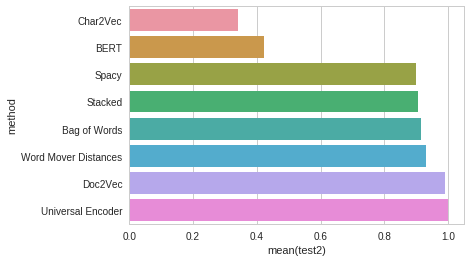

In [0]:
results_df = pd.DataFrame(results).sort_values(['test2']).reset_index(drop=True)
sns.barplot(x="test2", y="method", data=results_df)

# Test 3: Adversarial Sentences
This test uses sentences with similar wording but very different meanings (e.g. "dogs chase cats" vs "cats chase dogs")

In [13]:
!wget https://raw.githubusercontent.com/mohammedterry/NLP_for_ML/master/antimetabole.csv

--2019-03-16 22:23:03--  https://raw.githubusercontent.com/mohammedterry/NLP_for_ML/master/antimetabole.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2003 (2.0K) [text/plain]
Saving to: ‘antimetabole.csv’

antimetabole.csv    100%[===================>]   1.96K  --.-KB/s    in 0s      

2019-03-16 22:23:03 (39.4 MB/s) - ‘antimetabole.csv’ saved [2003/2003]



In [14]:
import pandas as pd
testbench3 = pd.read_csv("antimetabole.csv")
testbench3

,sentence,antimetabole,rephrase
0,I go where I please,I please where I go,I go wherever i want
1,Ask not what your country can do for you,ask what you can do for your country,don't ask what you can get out of your country
2,We do what we like,we like what we do,we do whatever we desire
3,be with the one you love,love the one you’re with,stay with your loved one
4,Fair is foul,foul is Fair,fairness sometimes seems unpleasant
5,the beginning of the end,the end of the beginning,the end has begun
6,People forget all those things they don't want...,people remember everything they don't want to ...,if someone doesn't want to remember it they wi...
7,describe the beautiful as ugly,describe the ugly as beautiful,depicting a beautiful thing as being unattractive
8,confuse the true with the false,confuse the false with the true,mistaking truth with falsehood
9,misery from power,power from misery,being in charge is not all fun


In [0]:
test_sentences3 = testbench3.values
meanings3 = testbench3.index.tolist()

In [0]:
def test3(svectors, topics, display = False):
  predicted_sentences = [most_similar(svector_triple[0], svector_triple, top_n = 2) for svector_triple in svectors]
  if display:
    marks = ("NA","❌","✅")
    for sentence,t,ppp in zip(test_sentences3,topics,predicted_sentences):
      p1,p2 = ppp
      print(f"\n({t}) {sentence[0]}:\n{marks[p1]}\t{test_sentences3[t][p1]}\n{marks[p2]}\t{test_sentences3[t][p2]}")
  predicted_topics = [topics[p2] for _,p2 in predicted_sentences]
  return sum([predicted == expected for predicted,expected in zip(predicted_topics, topics)]) / len(predicted_topics)

In [0]:
results["test3"] = []

### Method: BoWs

In [36]:
vocab = list({word for sentence_triplet in test_sentences3 for sentence in sentence_triplet for word in sentence.lower().split()})
bow_vectors3 = [bow_vector(sentence_triplet, vocab) for sentence_triplet in test_sentences3]
results["test3"].append(test3(bow_vectors3, meanings3, display = True))


(0) I go where I please:
NA	I go where I please
❌	I please where I go

(1) Ask not what your country can do for you:
NA	Ask not what your country can do for you
❌	ask what you can do for your country

(2) We do what we like:
NA	We do what we like
❌	we like what we do

(3) be with the one you love:
NA	be with the one you love
❌	love the one you’re with

(4) Fair is foul:
NA	Fair is foul
❌	foul is Fair

(5) the beginning of the end:
NA	the beginning of the end
❌	the end of the beginning

(6) People forget all those things they don't want to remember:
NA	People forget all those things they don't want to remember
❌	people remember everything they don't want to forget

(7) describe the beautiful as ugly:
NA	describe the beautiful as ugly
❌	describe the ugly as beautiful

(8) confuse the true with the false:
NA	confuse the true with the false
❌	confuse the false with the true

(9) misery from power:
NA	misery from power
❌	power from misery

(10) the power of love:
NA	the power of love
❌	the

### Method: Spacy

In [37]:
spacy_vectors3 = [[sp(sentence).vector for sentence in sentence_triplet] for sentence_triplet in test_sentences3]
results["test3"].append(test3(spacy_vectors3, meanings3, display = True))


(0) I go where I please:
NA	I go where I please
❌	I please where I go

(1) Ask not what your country can do for you:
NA	Ask not what your country can do for you
❌	ask what you can do for your country

(2) We do what we like:
NA	We do what we like
❌	we like what we do

(3) be with the one you love:
NA	be with the one you love
❌	love the one you’re with

(4) Fair is foul:
NA	Fair is foul
❌	foul is Fair

(5) the beginning of the end:
NA	the beginning of the end
❌	the end of the beginning

(6) People forget all those things they don't want to remember:
NA	People forget all those things they don't want to remember
❌	people remember everything they don't want to forget

(7) describe the beautiful as ugly:
NA	describe the beautiful as ugly
❌	describe the ugly as beautiful

(8) confuse the true with the false:
NA	confuse the true with the false
❌	confuse the false with the true

(9) misery from power:
NA	misery from power
❌	power from misery

(10) the power of love:
NA	the power of love
❌	the

### Method: Char2Vec 

In [38]:
c2v_vectors3 = c2v_model.vectorize_words(test_sentences3.flatten())
c2v_vectors3_reshaped = []
vector_triplet = []
for i,vector in enumerate(c2v_vectors3):
  vector_triplet.append(vector)
  if not (i+1)%3:
    c2v_vectors3_reshaped.append(vector_triplet)
    vector_triplet = []
results["test3"].append(test3(c2v_vectors3_reshaped, meanings3, display = True))


(0) I go where I please:
NA	I go where I please
❌	I please where I go

(1) Ask not what your country can do for you:
NA	Ask not what your country can do for you
❌	ask what you can do for your country

(2) We do what we like:
NA	We do what we like
❌	we like what we do

(3) be with the one you love:
NA	be with the one you love
✅	stay with your loved one

(4) Fair is foul:
NA	Fair is foul
✅	fairness sometimes seems unpleasant

(5) the beginning of the end:
NA	the beginning of the end
❌	the end of the beginning

(6) People forget all those things they don't want to remember:
NA	People forget all those things they don't want to remember
✅	if someone doesn't want to remember it they will forget it

(7) describe the beautiful as ugly:
NA	describe the beautiful as ugly
❌	describe the ugly as beautiful

(8) confuse the true with the false:
NA	confuse the true with the false
❌	confuse the false with the true

(9) misery from power:
NA	misery from power
❌	power from misery

(10) the power of lov

### Method: Doc2Vec

In [39]:
d2v_vectors3 = [[d2v_model.infer_vector(sentence.lower().split(), alpha=.01, steps=1000) for sentence in sentence_triplet] for sentence_triplet in test_sentences3]
results["test3"].append(test3(d2v_vectors3, meanings3, display = True))


(0) I go where I please:
NA	I go where I please
❌	I please where I go

(1) Ask not what your country can do for you:
NA	Ask not what your country can do for you
❌	ask what you can do for your country

(2) We do what we like:
NA	We do what we like
❌	we like what we do

(3) be with the one you love:
NA	be with the one you love
❌	love the one you’re with

(4) Fair is foul:
NA	Fair is foul
❌	foul is Fair

(5) the beginning of the end:
NA	the beginning of the end
❌	the end of the beginning

(6) People forget all those things they don't want to remember:
NA	People forget all those things they don't want to remember
❌	people remember everything they don't want to forget

(7) describe the beautiful as ugly:
NA	describe the beautiful as ugly
❌	describe the ugly as beautiful

(8) confuse the true with the false:
NA	confuse the true with the false
❌	confuse the false with the true

(9) misery from power:
NA	misery from power
❌	power from misery

(10) the power of love:
NA	the power of love
❌	the

### Method: BERT

In [40]:
bert_vectors3 = [[sentence_bert(sentence) for sentence in sentence_triplet] for sentence_triplet in test_sentences3]
results["test3"].append(test3(bert_vectors3, meanings3, display = True))


(0) I go where I please:
NA	I go where I please
❌	I please where I go

(1) Ask not what your country can do for you:
NA	Ask not what your country can do for you
❌	ask what you can do for your country

(2) We do what we like:
NA	We do what we like
✅	we do whatever we desire

(3) be with the one you love:
NA	be with the one you love
❌	love the one you’re with

(4) Fair is foul:
NA	Fair is foul
❌	foul is Fair

(5) the beginning of the end:
NA	the beginning of the end
❌	the end of the beginning

(6) People forget all those things they don't want to remember:
NA	People forget all those things they don't want to remember
❌	people remember everything they don't want to forget

(7) describe the beautiful as ugly:
NA	describe the beautiful as ugly
❌	describe the ugly as beautiful

(8) confuse the true with the false:
NA	confuse the true with the false
❌	confuse the false with the true

(9) misery from power:
NA	misery from power
❌	power from misery

(10) the power of love:
NA	the power of love

### Method: Universal Encoder

In [41]:
uni_vectors3 = universal_sentence(test_sentences3.flatten())
uni_vectors3_reshaped = []
vector_triplet = []
for i,vector in enumerate(uni_vectors3):
  vector_triplet.append(vector)
  if not (i+1)%3:
    uni_vectors3_reshaped.append(vector_triplet)
    vector_triplet = []
results["test3"].append(test3(uni_vectors3_reshaped, meanings3, display = True))


(0) I go where I please:
NA	I go where I please
✅	I go wherever i want

(1) Ask not what your country can do for you:
NA	Ask not what your country can do for you
❌	ask what you can do for your country

(2) We do what we like:
NA	We do what we like
❌	we like what we do

(3) be with the one you love:
NA	be with the one you love
✅	stay with your loved one

(4) Fair is foul:
NA	Fair is foul
❌	foul is Fair

(5) the beginning of the end:
NA	the beginning of the end
❌	the end of the beginning

(6) People forget all those things they don't want to remember:
NA	People forget all those things they don't want to remember
❌	people remember everything they don't want to forget

(7) describe the beautiful as ugly:
NA	describe the beautiful as ugly
❌	describe the ugly as beautiful

(8) confuse the true with the false:
NA	confuse the true with the false
❌	confuse the false with the true

(9) misery from power:
NA	misery from power
❌	power from misery

(10) the power of love:
NA	the power of love
❌	th

### Method: Stacked

In [44]:
stacked_vectors3 = [[np.concatenate(stack) for stack in zip(a,b,c,d,e,f) ] for a,b,c,d,e,f in zip(bow_vectors3, d2v_vectors3, spacy_vectors3, c2v_vectors3_reshaped, bert_vectors3, uni_vectors3_reshaped)]
results["test3"].append(test3(stacked_vectors3, meanings3, display = True))


(0) I go where I please:
NA	I go where I please
❌	I please where I go

(1) Ask not what your country can do for you:
NA	Ask not what your country can do for you
❌	ask what you can do for your country

(2) We do what we like:
NA	We do what we like
❌	we like what we do

(3) be with the one you love:
NA	be with the one you love
❌	love the one you’re with

(4) Fair is foul:
NA	Fair is foul
❌	foul is Fair

(5) the beginning of the end:
NA	the beginning of the end
❌	the end of the beginning

(6) People forget all those things they don't want to remember:
NA	People forget all those things they don't want to remember
❌	people remember everything they don't want to forget

(7) describe the beautiful as ugly:
NA	describe the beautiful as ugly
❌	describe the ugly as beautiful

(8) confuse the true with the false:
NA	confuse the true with the false
❌	confuse the false with the true

(9) misery from power:
NA	misery from power
❌	power from misery

(10) the power of love:
NA	the power of love
❌	the

### Method: WMD

In [0]:
def test3_wmd(sentences, topics, display = False):
  predicted_sentences = [most_similar_wmd(sentence_triplet[0], sentence_triplet, top_n = 2) for sentence_triplet in sentences]
  if display:
    marks = ("NA","❌","✅")
    for sentence,t,ppp in zip(sentences,topics,predicted_sentences):
      p1,p2 = ppp
      print(f"\n({t}) {sentence[0]}:\n{marks[p1]}\t{test_sentences3[t][p1]}\n{marks[p2]}\t{test_sentences3[t][p2]}")
  predicted_topics = [topics[p2] for _,p2 in predicted_sentences]
  return sum([predicted == expected for predicted,expected in zip(predicted_topics, topics)]) / len(predicted_topics)  

In [53]:
results["test3"].append(test3_wmd(test_sentences3, meanings3, display = True))


(0) I go where I please:
NA	I go where I please
❌	I please where I go

(1) Ask not what your country can do for you:
NA	Ask not what your country can do for you
❌	ask what you can do for your country

(2) We do what we like:
NA	We do what we like
❌	we like what we do

(3) be with the one you love:
NA	be with the one you love
❌	love the one you’re with

(4) Fair is foul:
NA	Fair is foul
❌	foul is Fair

(5) the beginning of the end:
NA	the beginning of the end
❌	the end of the beginning

(6) People forget all those things they don't want to remember:
NA	People forget all those things they don't want to remember
❌	people remember everything they don't want to forget

(7) describe the beautiful as ugly:
NA	describe the beautiful as ugly
❌	describe the ugly as beautiful

(8) confuse the true with the false:
NA	confuse the true with the false
❌	confuse the false with the true

(9) misery from power:
NA	misery from power
❌	power from misery

(10) the power of love:
NA	the power of love
❌	the

## Test 3 Results

In [56]:
import pandas as pd
pd.DataFrame(results)

,method,test3
0,Bag of Words,0.04
1,Spacy,0.04
2,Char2Vec,0.04
3,Doc2Vec,0.04
4,BERT,0.08
5,Universal Encoder,0.04
6,Stacked,0.04
7,Word Mover Distances,0.04


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


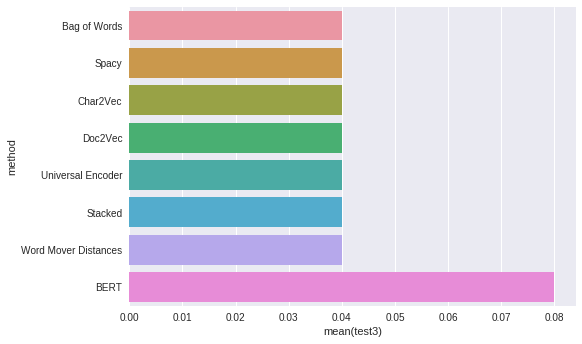

In [58]:
results_df = pd.DataFrame(results).sort_values(['test3']).reset_index(drop=True)
sns.barplot(x="test3", y="method", data=results_df)